# Chromosome Painting

In [1]:
using Revise
using VCFTools
using MendelImpute
using VariantCallFormat
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using JLSO
using BenchmarkTools
using GroupSlices
using LinearAlgebra
using DataFrames
using Plots
using StatsPlots
# using ProfileView

BLAS.set_num_threads(1)

# Download population data

Download [population code](ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/) for each 1000 genomes sample. Different population code is explained [here](https://www.internationalgenome.org/category/population/). 

In [2]:
# run this code in terminal
# wget -r -l3 -N --no-parent ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/

In [2]:
refID_to_population = thousand_genome_samples_to_population()
refID_to_superpopulation = thousand_genome_samples_to_super_population()

Dict{String, String} with 2504 entries:
  "HG01791" => "EUR"
  "HG02736" => "SAS"
  "HG00182" => "EUR"
  "HG03914" => "SAS"
  "HG00149" => "EUR"
  "NA12156" => "EUR"
  "HG02642" => "AFR"
  "HG02851" => "AFR"
  "NA19835" => "AFR"
  "NA19019" => "AFR"
  "HG01131" => "AMR"
  "HG03578" => "AFR"
  "NA18550" => "EAS"
  "HG02401" => "EAS"
  "HG01350" => "AMR"
  "HG03973" => "SAS"
  "NA07000" => "EUR"
  "HG01709" => "EUR"
  "HG01395" => "AMR"
  "HG01980" => "AMR"
  "HG01979" => "AMR"
  "HG01122" => "AMR"
  "HG03869" => "SAS"
  "HG03729" => "SAS"
  "NA19920" => "AFR"
  ⋮         => ⋮

# Local ancestry estimates

Here the target and reference files are generated with the `aim_select.ipynb` notebook under `aim_markers`. 

In [5]:
# colors generated here: https://sashamaps.net/docs/resources/20-colors/
continent = ["SAS", "EAS", "EUR", "AFR"]
continent_colors = [colorant"#450817", colorant"#a11235", colorant"#4363d8", colorant"#bfef45"]

tgtfile = "target.chr18.typedOnly.aim.masked.vcf.gz"
reffile = "ref.chr18.jlso"
Q, pop_colors = admixture_local(tgtfile, reffile, refID_to_superpopulation, 
    continent, continent_colors)

Number of threads = 1
Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:36
Phasing...100%|█████████████████████████████████████████| Time: 0:00:14


Total windows = 799, averaging ~ 492 unique haplotypes per window.

Timings: 
    Data import                     = 12.9055 seconds
        import target data             = 4.79673 seconds
        import compressed haplotypes   = 8.10873 seconds
    Computing haplotype pair        = 36.3457 seconds
        BLAS3 mul! to get M and N      = 0.885387 seconds per thread
        haplopair search               = 35.08 seconds per thread
        initializing missing           = 0.247608 seconds per thread
        allocating and viewing         = 0.0775928 seconds per thread
        index conversion               = 0.0459424 seconds per thread
    Phasing by win-win intersection = 14.822 seconds
        Window-by-window intersection  = 1.21513 seconds per thread
        Breakpoint search              = 13.0521 seconds per thread
        Recording result               = 0.513522 seconds per thread
    Imputation                     = 0.296241 seconds
        Imputing missing               = 0.0

([0.003479935538504484 0.0005606367332002505 … 0.0 0.0; 0.0008280534176556001 0.003192579890734481 … 0.0 0.0; … ; 0.0013664054271512382 0.0024630484094571676 … 0.0 0.0; 0.0038341453573883244 0.0004222368701926573 … 0.0 0.0], RGB{FixedPointNumbers.N0f8}[RGB{N0f8}(0.263,0.388,0.847) RGB{N0f8}(0.263,0.388,0.847) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.263,0.388,0.847) RGB{N0f8}(0.271,0.031,0.09) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); … ; RGB{N0f8}(0.263,0.388,0.847) RGB{N0f8}(0.263,0.388,0.847) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0); RGB{N0f8}(0.263,0.388,0.847) RGB{N0f8}(0.263,0.388,0.847) … RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.0,0.0,0.0)])

In [6]:
# 3 selected sample's composition (PUR, PEL, ASW)
tgtID = sampleID(tgtfile)
sample1 = findfirst(isequal("HG00553"), tgtID)
sample2 = findfirst(isequal("HG02348"), tgtID)
sample3 = findfirst(isequal("NA20356"), tgtID)

@show sample1, sample2, sample3

# every 2 column is 1 sample, so sample 2 haplotype is in column 3, 4 ... etc
idx = [3, 4, 339*2 - 1, 339*2, 500 * 2-1, 500*2]

(sample1, sample2, sample3) = (2, 339, 500)


6-element Vector{Int64}:
    3
    4
  677
  678
  999
 1000

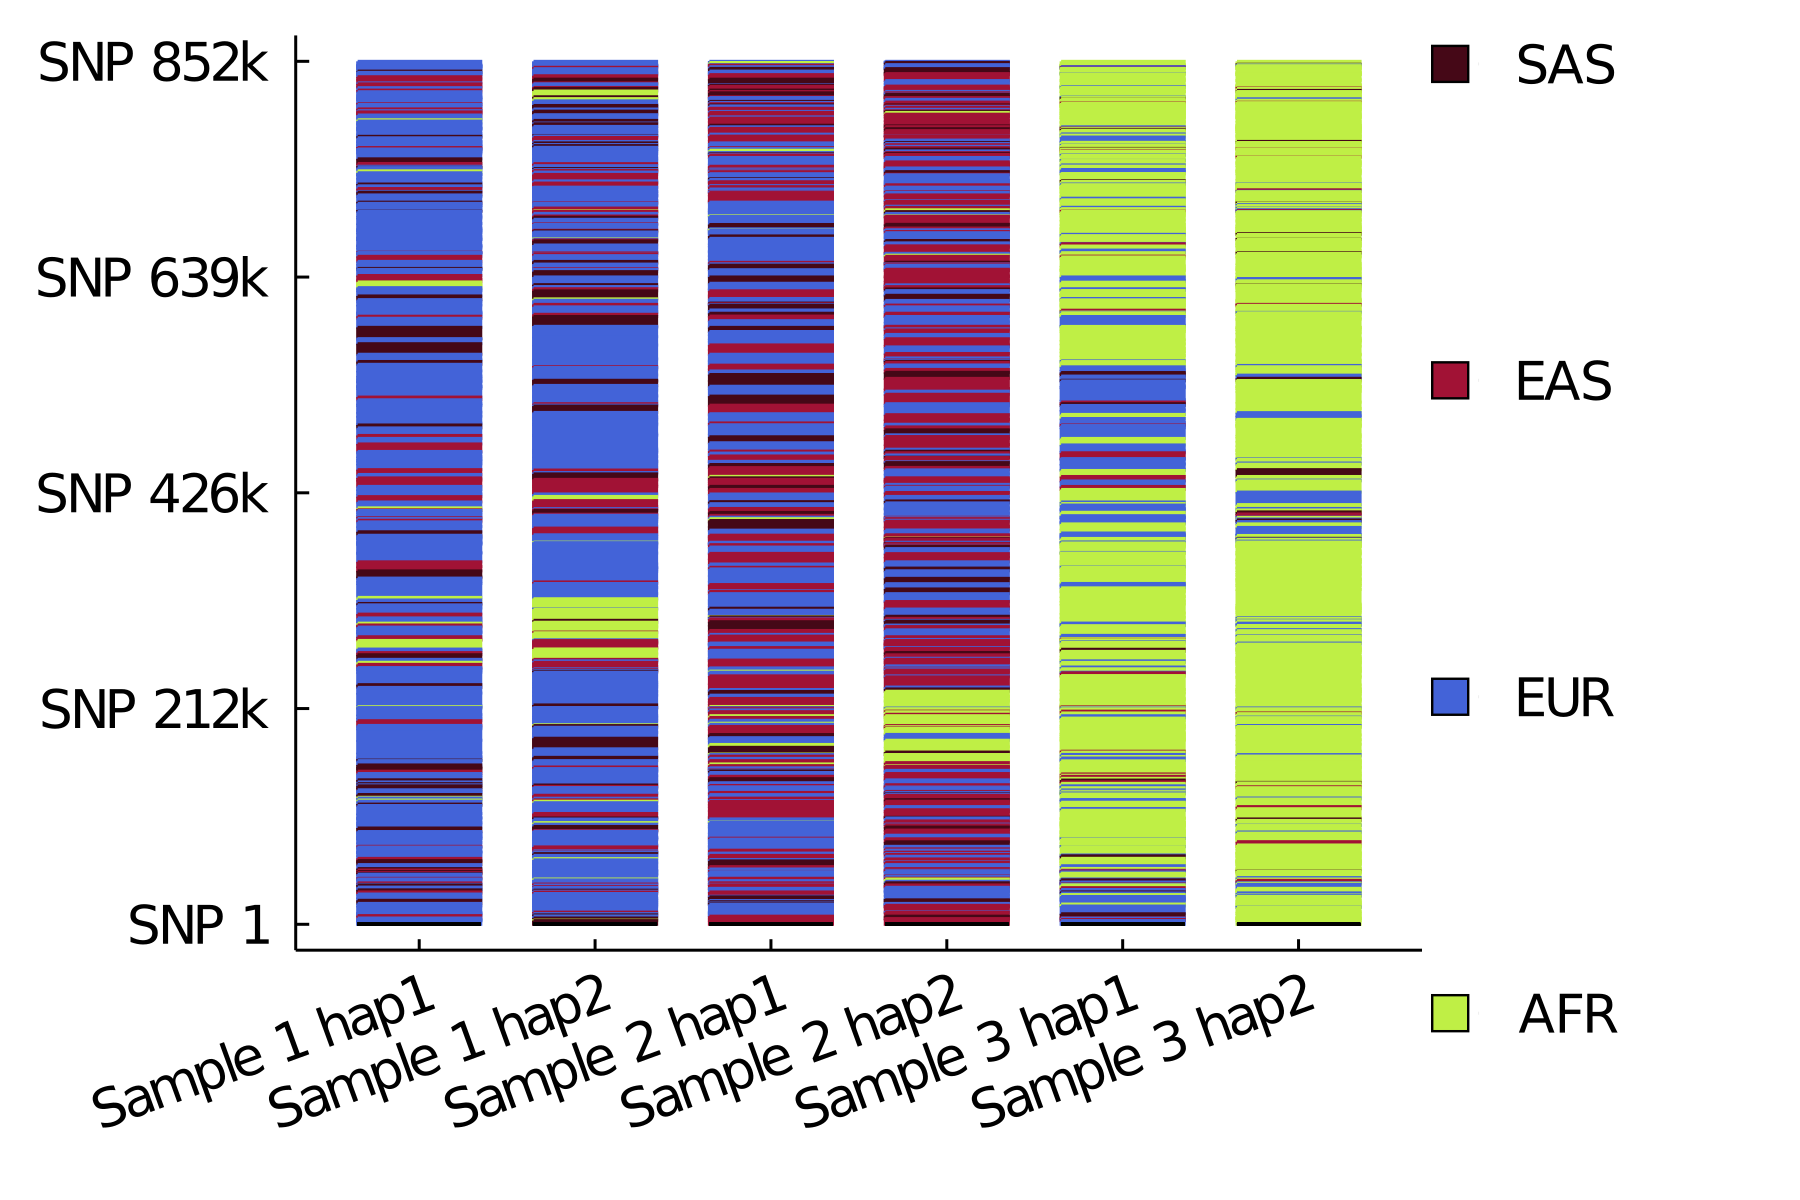

In [7]:
# color haplotypes
sample_Q = Q[idx, :]
sample_color = pop_colors[idx, :]
xnames = ["Sample 1 hap1", "Sample 1 hap2", "Sample 2 hap1", "Sample 2 hap2", 
        "Sample 3 hap1", "Sample 3 hap2"]
ynames = ["SNP 1", "SNP 212k", "SNP 426k", "SNP 639k", "SNP 852k"]
local_plt = groupedbar(sample_Q, bar_position = :stack, bar_width=0.7, label=:none, 
    color=sample_color, xticks=(1:1:6, xnames), yticks=(0:0.25:1, ynames),
    ytickfont=font(12), xtickfont=font(12), xrotation=20, grid=false, dpi=300,
    right_margin = 30Plots.mm, linecolor=:match)

# create a separate plot for legend
scatter!(local_plt, ones(4), collect(1:4), color=reverse(continent_colors), ytick=(1:4, reverse(continent)), 
    xrange=(0.9, 1.1), xtick=false, label=:none, markersize=6, ytickfont=font(12),
    grid=false, framestyle=:grid, mirror=true, tick_direction=:out, markershape=:rect,
    inset = (1, bbox(-0.05, -0.1, 0.05, 1.1, :bottom, :right)), subplot = 2)

# save figure
savefig(local_plt, "local_admixture.png")
display("image/png", read("local_admixture.png"))

# Run ADMIXTURE

In [4]:
using ADMIXTURE, SnpArrays

In [5]:
# first convert target file to PLINK format
tgtfile = "target.chr18.typedOnly.aim.masked.vcf.gz"
vcf2plink(tgtfile, "target.chr18.typedOnly.aim.masked")

# run ADMIXTURE with K = 4
P, Q = admixture("target.chr18.typedOnly.aim.masked.bed", 4);

****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.


┌ Info: ADMIXTURE command:
│ `/Users/biona001/.julia/artifacts/7d0732a6f20d0cf8c106525a4602fc824e4cff31/dist/admixture_macosx-1.3.0/admixture /Users/biona001/.julia/dev/MendelImpute/manuscript/sec4.3/target.chr18.typedOnly.aim.masked.bed 4`
└ @ ADMIXTURE /Users/biona001/.julia/packages/ADMIXTURE/LIsH7/src/ADMIXTURE.jl:59
┌ Info: Output directory: /Users/biona001/.julia/dev/MendelImpute/manuscript/sec4.3
└ @ ADMIXTURE /Users/biona001/.julia/packages/ADMIXTURE/LIsH7/src/ADMIXTURE.jl:60


Size of G: 811x49993
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 2.478	Loglikelihood: -4.04554e+07	(delta): 2.23582e+07
2 (EM) 	Elapsed: 2.568	Loglikelihood: -3.92654e+07	(delta): 1.18992e+06
3 (EM) 	Elapsed: 2.588	Loglikelihood: -3.89454e+07	(delta): 320024
4 (EM) 	Elapsed: 2.541	Loglikelihood: -3.87618e+07	(delta): 183582
5 (EM) 	Elapsed: 2.936	Loglikelihood: -3.86354e+07	(delta): 126428
Initial loglikelihood: -3.86354e+07
Starting main algorithm
1 (QN/Block) 	Elapsed: 4.695	Loglikelihood: -3.53404e+07	(delta): 3.295e+06
2 (QN/Block) 	Elapsed: 5.025	Loglikelihood: -3.41782e+07	(delta): 1.16226e+06
3 (QN/Block) 	Elapsed: 5.325	Loglikelihood: -3.37991e+07	(delta): 379038
4 (QN/Block) 	Elapsed: 6.161	Loglikelihood: -3.35203e+07	(delta): 278779
5 (QN/Block) 	Elapsed: 5.402	Loglikelihood: -3.34338e+07	(delta): 86583.8
6 (QN/Block) 	Elapsed: 6.314	Loglikelihood: -3.34079e+07	(delta): 25854.4
7 (QN/Block) 	Elapsed: 5.321	Loglikelihood: -3.3383e+07	(delta): 24912.7
8 (Q

In [6]:
# PUR, PEL, ASW
sample1 = 2
sample2 = 339
sample3 = 704

Q[sample1, :]

4-element Vector{Float64}:
 0.135974
 0.647946
 0.051588
 0.164492

In [7]:
Q[sample2, :]

4-element Vector{Float64}:
 0.17571
 1.0e-5
 0.021041
 0.803239

In [8]:
Q[sample3, :]

4-element Vector{Float64}:
 0.140126
 1.0e-5
 0.859854
 1.0e-5